<a id='top'></a>
<h1 align="center">MCMC Tutorial Part 2</h1>

**Authors:** John Letey, Mingxuan Zhang, and Tony E Wong

### Table of Contents

- [Packages](#packages)
- [Part A](#part-a)
- [Part B](#part-b)

<a id='packages'></a>
***
<h2 align="center">Packages</h2>
[Back to top](#top)

<br>

These are all of the packages we are going to be using:

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
COLORS = ["skyblue", "steelblue", "gray"]
ALPHAS = [1.0, 1.0, 0.45]

***

<a id='part-a'></a>
***
<h1 align="center">Part A</h1>

### Table of Contents

- [Generate Synthetic Data](#a-synthetic-data_norm)
- [Log-Likelihood Function](#a-log-likelihood_norm)
- [Log-Prior Distribution](#a-log-prior_norm)
- [Log-Posterior Distribution](#a-log-posterior_norm)
- [Adaptive Metropolis-Hastings Algorithm](#a-amha)
- [Running the Algorithm](#a-run-algo_norm)
- [History Plots For Each Parameter](#history-plots_norm)
- [Gelman-Rubin Diagnostic Results](#gr-diagnostic_norm)
- [Auto Correlation Function Results](#ac-function_norm)
- [Histograms For Each Parameter](#histograms_norm)
- [Max Log-Posterior Score Parameter Set](#max-ls_norm)

<a id='a-synthetic-data_norm'></a>
***
<h2 align="center">Generate Synthetic Data</h2>
[Back to top](#top)

<br>

Since this tutorial is focused on the fact that we're fitting a normal distribution given that we have some known parameters, lets first generate the random normal distribution that we are going to fit given parameters $\mu = 10$ and $\sigma = 10$:

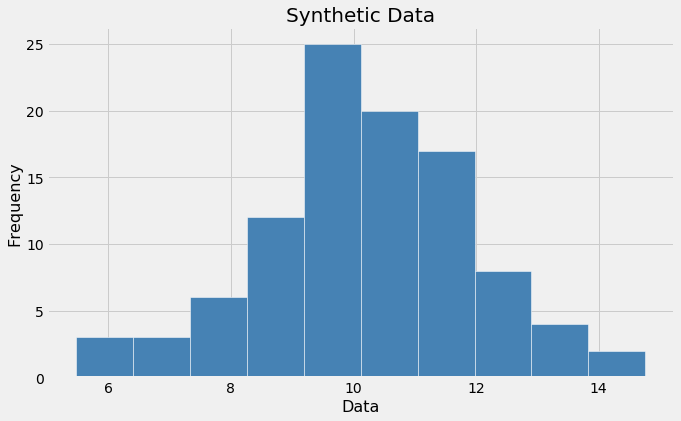

In [143]:
def generate_synthetic_data(mu, sigma, plot=False):
    data_meas = stats.norm.rvs(loc=mu, scale=sigma, size=100)
    if plot:
        plt.figure(figsize=(10, 6))
        plt.hist(data_meas, facecolor="steelblue", edgecolor="white")
        plt.title("Synthetic Data", fontsize=20)
        plt.xlabel("Data", fontsize=16)
        plt.ylabel("Frequency", fontsize=16)
        plt.axis(alpha=.5)
        plt.show()
    return data_meas

mu_param, sigma_param = 10, 2
data_meas1 = generate_synthetic_data(mu_param, sigma_param, True)

***

<a id='a-log-likelihood_norm'></a>
***
<h2 align="center">Log-Likelihood Function</h2>
[Back to top](#top)

In [144]:
def loglikelihood_normal(parameters, data_meas):
    mu, sigma = parameters
    s = 0
    for i in range(len(data_meas)):
        logpdf = stats.norm.logpdf(x=data_meas[i], loc=mu, scale=sigma)
        if logpdf == -np.inf:
            return -np.inf
        s += logpdf
    return s

***

<a id='a-log-prior_norm'></a>
***
<h2 align="center">Log-Prior Distribution</h2>
[Back to top](#top)

In [145]:
def logprior_normal(parameters):
    mu, sigma = parameters
    
    mu_logpdf = stats.norm.logpdf(x=mu, loc=0, scale=1000)
    
    if sigma <= 0 or sigma >= 1000:
        return -np.inf
    
    return mu_logpdf + np.log(1 / 1000)

***

<a id='a-log-posterior_norm'></a>
***
<h2 align="center">Log-Posterior Distribution</h2>
[Back to top](#top)

In [146]:
def logpost_normal(parameters, data_meas):
    pi = logprior_normal(parameters)
    if pi == -np.inf:
        return -np.inf
    LL = loglikelihood_normal(parameters, data_meas)
    return LL + pi

***

<a id='a-amha'></a>
***
<h2 align="center">Adaptive Metropolis-Hastings Algorithm</h2>
[Back to top](#top)

<br>

The Adaptive Metropolis (AM) algorithm of Haario et al. (2001) is an extension of the Metropolis-Hastings algorithm that adapts based on the observed covariance matrix from the history of the chains. AM is historically significant as the first adaptive MCMC algorithm.

In [147]:
class State: 
    def __init__(self, state, value):
        self.state = state 
        self.value = value 

class ProblemMCMC: 
    def __init__(self, initial, logposterior, stepsize, data_meas, t, d):
        self.current = initial 
        self.logpost = logposterior 
        self.stepsize = stepsize 
        self.data_meas = data_meas
        self.t = t
        self.I_d = np.identity(d)
        self.S_d = (2.4)**2/d
        self.d = d
        
    def random_move(self, t, X):
        if (t <= self.t):
            next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        else:
            cov = self.S_d*np.cov(X) + self.I_d*0.0001*self.S_d
            next_move = stats.multivariate_normal.rvs(self.current.state, cov)
        return next_move, self.logpost(next_move, self.data_meas)

In [148]:
def adaptivemcmc(problem, n_iter):
    parameters = []
    for i in range(problem.d):
        parameters.append([])
        parameters[i].append(problem.current.state[i])
    lpost = [problem.current.value]    
    n_accept = 0
    S = 0
    np.seterr(over='ignore')
    
    for t in range(n_iter):
        S += 1
        nextMove, nextValue = problem.random_move(t, parameters)
        delta_obj = np.exp(nextValue - lpost[-1])
        if delta_obj > 1:
            n_accept += 1
            for i in range(problem.d):
                parameters[i].append(nextMove[i])
            lpost.append(nextValue)
            problem.current.state = nextMove
            problem.current.value = nextValue
        else:
            p_accept = delta_obj
            accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
            if accept:
                n_accept += 1
                for i in range(problem.d):
                    parameters[i].append(nextMove[i])
                lpost.append(nextValue)
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                for i in range(problem.d):
                    parameters[i].append(parameters[i][-1])
                lpost.append(lpost[-1])

    return (parameters, lpost, n_accept/S)

***

<a id='a-gr-diagnostic'></a>
***
<h2 align="center">Gelman-Rubin Diagnostic</h2>
[Back to top](#top)

In [149]:
def GR_diag(parameter, interval=100, start=100):
    # go through each of the chains and calculate the
    # potential scale reduction factor
    end = len(parameter[0])
    m = len(parameter)
    GR_result = []
    for n in range(start, end, interval):
        sequences = []
        for i in range(m):
            sequences.append(parameter[i][:n])
        GR_result.append(psrf(sequences))
    burnin = 0
    for i in range(len(GR_result)):
        if max(GR_result[i:]) < 1.1:
            burnin = i+1
            break
    return GR_result, burnin*interval

def psrf(chains):
    # u_i - the average for each chain
    u = [np.mean(chain) for chain in chains]
    # s_i - the variance for each chain
    s = [np.var(chain, ddof=1) for chain in chains]
    # m - the number of sequences
    m = len(chains)
    # n - the length of each chain
    n = len(chains[0])
    # ubar - the overall average of the chains
    ubar = np.mean(u)
    # B, W - find the bewteen- and within-chain variance
    B, W = 0, 0
    for i in range(m):
        B += (u[i] - ubar)**2
        W += s[i]
    B = (B*n)/(m-1)
    W = W/m
    # Var - the overall variance of the chains
    Var = (1-(1/n))*W + (B/n)
    # R - the potential scale reduction factor
    return np.sqrt(Var/W)

def GR_result(mcmc_chains, params, t, start=100, interval=100, plot=True):
    m, d, n = len(mcmc_chains), len(mcmc_chains[0]), len(mcmc_chains[0][0])
    params_raw, GR_params, burnin_params = [], [], []
    start, interval, end = start, interval, n
    for i in range(d):
        params_raw.append([])
        for j in range(m):
            params_raw[i].append(mcmc_chains[j][i])
    for i in range(d):
        GR, burnin = GR_diag(params_raw[i], interval, start)
        GR_params.append(GR)
        burnin_params.append(burnin)
    burnin = max(max(burnin_params), t)
    if plot:
        plt.figure(figsize=(14, 6))
        for i in range(d):
            plt.scatter(x=np.arange(start, end, interval), y=GR_params[i], label=params[i], color=COLORS[i % 3])
        plt.plot([burnin, burnin], plt.ylim(), label='burn in = {0}'.format(burnin))
        plt.xlabel('Iteration', fontsize=14)
        plt.ylabel('Potential Scale Reduction Fator', fontsize=14)
        plt.title('Gelman & Rubin Diagnostic', fontsize=14)
        plt.legend(loc='best')
        plt.show()
    return burnin

***

<a id='a-ac-function'></a>
***
<h2 align="center">Auto-Correlation Function</h2>
[Back to top](#top)

In [150]:
def ACF(X, end=200):
    N = len(X)
    acf = []
    for a in range(0, end):
        acf.append(np.corrcoef(X[a:], X[:N-a])[0][1])
        
    lag = -1
    for i in range(len(acf)):
        if acf[i] <= 0.05:
            lag = i
            break
    if lag == -1:
        print ("Please increase the value of the end parameter for this function")
    return lag, acf

def acf_result(mcmc_chains, params, burnin, plot=True):
    lag_params, acf_params = [], []
    m, d, n = len(mcmc_chains), len(mcmc_chains[0]), len(mcmc_chains[0][0])
    end = 100
    for i in range(d):
        lag_params.append([])
        acf_params.append([])
        for j in range(m):
            lag, acf = ACF(mcmc_chains[j][i][burnin:], end)
            lag_params[i].append(lag)
            acf_params[i].append(acf)
    lags = [max(np.array(lag_params)[:,i]) for i in range(m)]
    
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=m, figsize=(25,6))
        for i in range(m):
            for j in range(d):
                ax[i].scatter(np.arange(0, end), acf_params[j][i], label=params[j], color=COLORS[j % 3])
                ax[i].fill_between(x=np.arange(0, end), y2=np.zeros_like(acf_params[j][i]), y1=acf_params[j][i], alpha=0.3, facecolor='skyblue')
            ax[i].plot([lags[i],lags[i]], ax[i].get_ylim(), label='lag = {0}'.format(lags[i]))
            ax[i].set_xlabel("Iag")
            ax[i].set_ylabel("ACF")
            ax[i].set_title("Sequence {0}".format(i+1))
            ax[i].legend(loc='best')
            ax[i].grid(alpha=0.5)
        plt.show()
    return lags

***

<a id='a-run-algo_norm'></a>
***
<h2 align="center">Running the Algorithm</h2>
[Back to top](#top)

<br>

Finally, we can start the Adaptive MCMC algorithm... we will generate three sequences each with 10000 iterations:

In [151]:
def runner(
    m, n_iter, d, logpost, data_meas, t=1000, stepsize=[0.01, 0.01]
):
    # set up the different chains
    chains = []
    for i in range(m):
        mu_init = np.random.randint(low=6, high=12)
        sigma_init = np.random.randint(low=1, high=4)
        theta = [mu_init, sigma_init]
        state = State(theta, logpost(theta, data_meas))
        chains.append(ProblemMCMC(state, logpost, stepsize, data_meas, t, d))
    # run the algorithm on all of the chains
    ar, mcmc_chains, ls = [], [], []
    for i in range(m):
        parameters, l, r = adaptivemcmc(chains[i], n_iter)
        mcmc_chains.append(parameters)
        ar.append(r)
        ls.append(l)
    # return
    return mcmc_chains, ar, ls

In [152]:
t=1000
mcmc_chains1, ar1, ls1 = runner(m=3, n_iter=10000, t=t, data_meas=data_meas1, d=2, logpost=logpost_normal)

***

<a id='history-plots_norm'></a>
***
<h2 align="center">History plots for each parameter</h2>
[Back to top](#top)

<br>

In [153]:
def history_plots(mcmc_chains, params, true_params=None):
    m = len(mcmc_chains)
    fig, ax = plt.subplots(nrows=1, ncols=len(params), figsize=(16, 6))
    fig.suptitle("History Plots", fontsize=20)
    for i in range(len(params)):
        for j in range(m):
            ax[i].plot(
                mcmc_chains[j][i],
                label="Sequence {0}".format(j + 1),
                color=COLORS[j % 3],
                alpha=ALPHAS[j % 3],
            )
        if true_params is not None:
            ax[i].plot(
                ax[i].get_xbound(),
                [true_params[i], true_params[i]],
                color="black",
                linestyle="dashed",
                label=params[i] + " true value",
                linewidth=2.5,
            )
        ax[i].set_xlabel("Iteration", fontsize=16)
        ax[i].set_ylabel(params[i] + " Trace", fontsize=16)
        ax[i].legend(loc="best")
    plt.show()

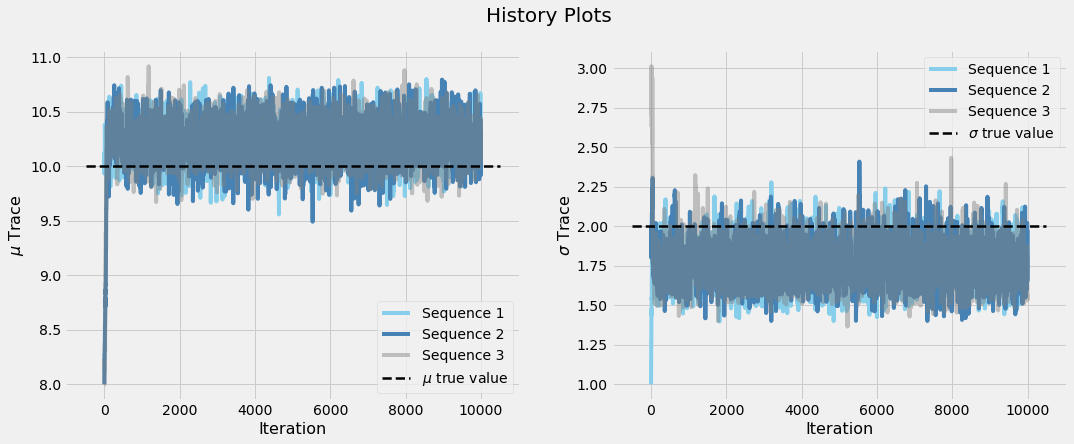

In [154]:
history_plots(mcmc_chains1, [r"$\mu$", r"$\sigma$"], [10, 2])

***

<a id='gr-diagnostic_norm'></a>
***
<h2 align="center">Gelman-Rubin Diagnostic Results</h2>
[Back to top](#top)

<br>

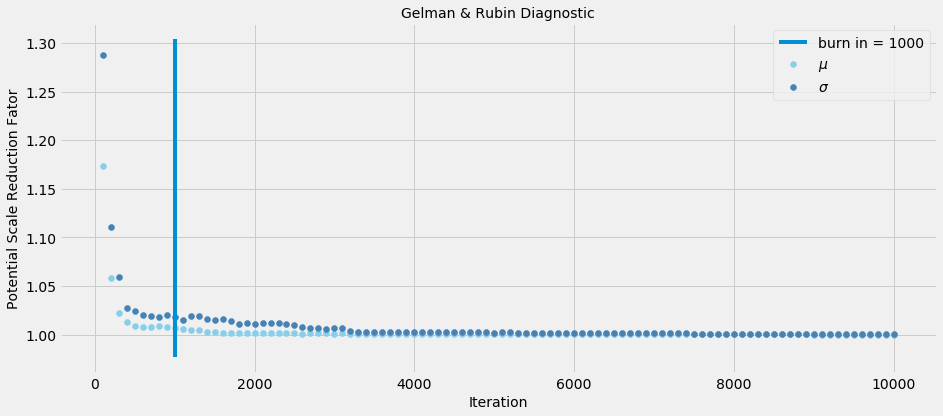

In [155]:
burnin1 = GR_result(mcmc_chains1, [r"$\mu$", r"$\sigma$"], t)

***

<a id='ac-function_norm'></a>
***
<h2 align="center">Auto Correlation Function Results</h2>
[Back to top](#top)

<br>

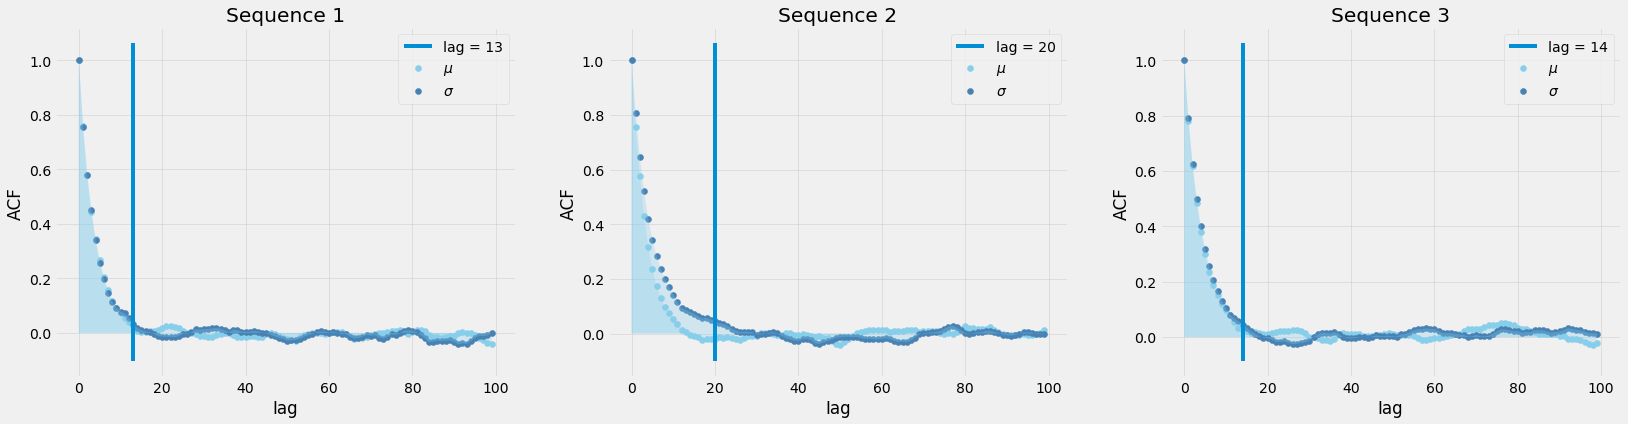

In [157]:
lags1 = plot_acf(mcmc_chains1, [r"$\mu$", r"$\sigma$"], burnin1)

***

<a id='histograms_norm'></a>
***
<h2 align="center">Histograms For Each Parameter</h2>
[Back to top](#top)

<br>

In [158]:
def final_params_pool(mcmc_chains, burnin, lags, params, plot=True):
    m, d, n = len(mcmc_chains), len(mcmc_chains[0]), len(mcmc_chains[0][0])
    params_pool, params_ana = [], [[] for i in range(d)]
    for i in range(m):
        for j in range(burnin, n, lags[i]):
            params_pool.append([])
            for k in range(d):
                params_ana[k].append(mcmc_chains[i][k][j])
                params_pool[-1].append(mcmc_chains[i][k][j])
            
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=d, figsize=(16,6))
        for i in range(d):
            ax[i].hist(params_ana[i], color="steelblue")
            ax[i].set_xlabel(params[i])
            ax[i].set_ylabel("Frequency")
            ax[i].grid(alpha=0.5)
        plt.show()  
    return params_pool

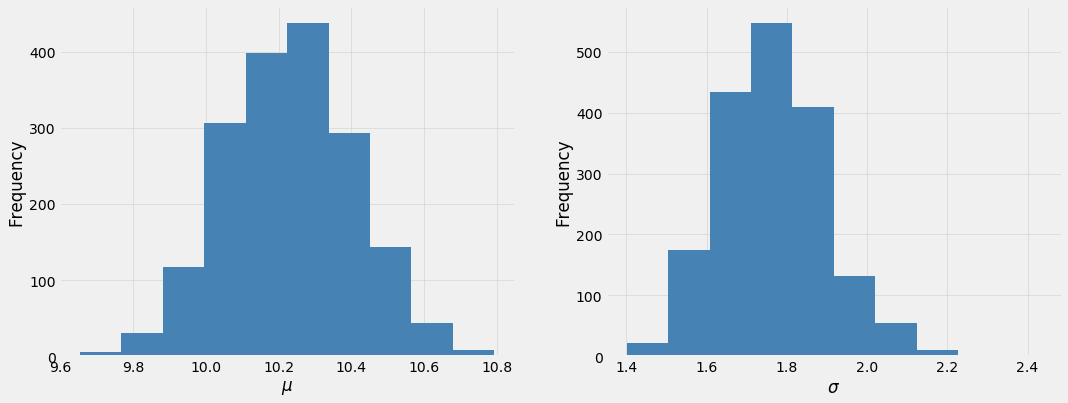

In [159]:
params_analysis1 = final_params_pool(mcmc_chains1, burnin1, lags1, [r"$\mu$", r"$\sigma$", r"$\xi$"])

***

<a id='max-ls_norm'></a>
***
<h2 align="center">Max Log-Posterior Score Parameter Set</h2>
[Back to top](#top)

<br>

In [160]:
def max_ls_parameters(ls, mcmc_chains):
    max_indices = []
    maxs = []
    for i in range(len(mcmc_chains)):
        max_indices.append(np.where(np.array(ls[i]) == np.array(ls[i]).max())[0][0])
        maxs.append(np.array(ls[i]).max())
    seqi = np.where(np.array(maxs) == np.array(maxs).max())[0][0]
    iterj = max_indices[seqi]
    max_params = []
    d = len(mcmc_chains[0])
    for i in range(d):
        max_params.append(mcmc_chains[seqi][i][iterj])
    print ('The parameters with max log-posterior score are',max_params)
    return max_params

In [190]:
max_params1 = max_ls_parameters(ls1, mcmc_chains1)

The parameters with max log-posterior score are [10.234692335256881, 1.732174653201016]


***

***

<a id='part-b'></a>
***
<h1 align="center">Part B</h1>

### Table of Contents

- [Generate Synthetic Data](#b-synthetic-data_gev)
- [Log-Likelihood Function](#b-log-likelihood_gev)
- [Log-Prior Distribution](#b-log-prior_gev)
- [Log-Posterior Distribution](#b-log-posterior_gev)
- [Running the Algorithm](#b-run-algo_gev)
- [History Plots For Each Parameter](#history-plots_gev)
- [Gelman-Rubin Diagnostic Results](#gr-diagnostic_gev)
- [Auto Correlation Function Results](#ac-function_gev)
- [Histograms For Each Parameter](#histograms_gev)
- [Max Log-Posterior Score Parameter Set](#max-ls_gev)
- [Diagnostic Plots](#diagnostic-plots_gev)

<a id='b-synthetic-data_gev'></a>
***
<h2 align="center">Generate Synthetic Data</h2>
[Back to top](#top)

<br>

Since this tutorial is focused on the fact that we're fitting a gev distribution given that we have some known parameters, lets first generate the random gev distribution that we are going to fit given parameters $\mu = 400$ and $\sigma = 100$ and $\xi = -0.4$, note that $\xi \Rightarrow \text{shape parameter}$:

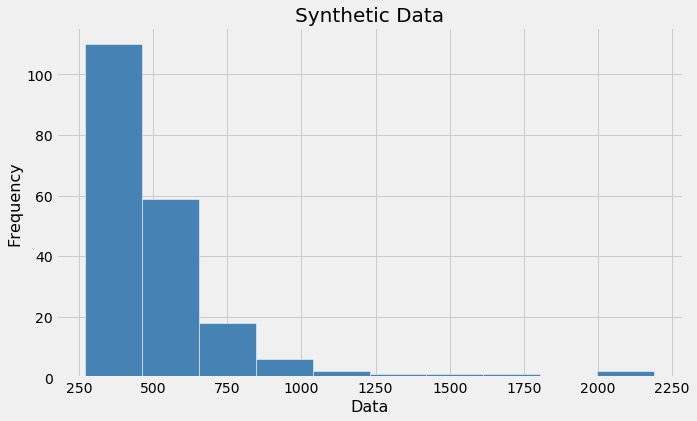

In [193]:
def generate_synthetic_data_gev(mu, sigma, shape, plot=False):
    data_meas = stats.genextreme.rvs(loc=mu, scale=sigma, c=shape, size=200)
    if plot:
        plt.figure(figsize=(10, 6))
        plt.hist(data_meas, facecolor="steelblue", edgecolor="white")
        plt.title("Synthetic Data", fontsize=20)
        plt.xlabel("Data", fontsize=16)
        plt.ylabel("Frequency", fontsize=16)
        plt.axis(alpha=.5)
        plt.show()
    return data_meas

mu_param, sigma_param, shape_param = 400, 100, -0.4
data_meas2 = generate_synthetic_data_gev(mu_param, sigma_param, shape_param, True)

***

<a id='b-log-likelihood_gev'></a>
***
<h2 align="center">Log-Likelihood Function</h2>
[Back to top](#top)

<br>

The likelihood function is almost exactly the same as the previous tutorial (Part 2A), but now instead of using the Normal distribution's PDF, we are going to use the GEV distribution's PDF:

In [165]:
def loglikelihood_gev(parameters, data_meas):
    mu, sigma, shape = parameters
    s = 0
    for i in range(len(data_meas)):
        logpdf = stats.genextreme.logpdf(x=data_meas[i], loc=mu, scale=sigma, c=shape)
        if logpdf == -np.inf:
            return -np.inf
        s += logpdf
    return s

***

<a id='b-log-prior_gev'></a>
***
<h2 align="center">Log-Prior Distribution</h2>
[Back to top](#top)

<br>

In [166]:
def logprior_gev(parameters):
    mu, sigma, shape = parameters
    mu_logpdf = stats.norm.logpdf(x=mu, loc=0, scale=1000)
    shape_logpdf = stats.norm.logpdf(x=shape, loc=0, scale=1000)
    if sigma >= 10000 or sigma <= 0:
        return -np.inf
    else:
        return mu_logpdf + np.log(1 / 10000) + shape_logpdf

***

<a id='b-log-posterior_gev'></a>
***
<h2 align="center">Log-Posterior Distribution</h2>
[Back to top](#top)

<br>

Same as the previous tutorials, the log-posterior is still just the sum of the log-prior and the log-posterior:

In [168]:
def logpost_gev(parameters, data_meas):
    pi = logprior_gev(parameters)
    if pi == -np.inf:
        return -np.inf
    LL = loglikelihood_gev(parameters, data_meas)
    return LL + pi

***

<a id='b-run-algo_gev'></a>
***
<h2 align="center">Running the Algorithm</h2>
[Back to top](#top)

<br>

Finally, we can start the Adaptive MCMC algorithm... we will generate three sequences each with 10000 iterations:

In [169]:
def sequences_generator(m, n_iter, data_meas, logpost, d, t=1000, stepsize=[10, 2, 0.01]):
    np.seterr(divide='ignore', invalid='ignore')
    loc_est = np.median(data_meas)
    scale_est = (np.percentile(data_meas, 75) - np.percentile(data_meas, 25))/2
    shape_est = 0
    gevfit = stats.genextreme.fit(data_meas, loc=loc_est, scale=scale_est)
    
    if logpost([gevfit[1], gevfit[2], gevfit[0]], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = gevfit[1], gevfit[2], gevfit[0]
        
    elif logpost([loc_est, scale_est, -0.1], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = loc_est, scale_est, -0.1
        
    elif logpost([loc_est, scale_est, 0.1], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = loc_est, scale_est, 0.1
        
    else:
        loc_est, scale_est, shape_est = loc_est, scale_est, 0
        
    problems = []
    for i in range(m):
        ui = np.random.randint(low=loc_est, high=loc_est+100)
        si = np.random.randint(low=scale_est, high=scale_est+100)
        shapei = shape_est
        theta =[ui, si, shapei]
        state = State(theta, logpost(theta, data_meas))
        problems.append(ProblemMCMC(state, logpost, stepsize, data_meas, t, d))
    ar, mcmc_chains, ls = [], [], []
    for i in range(m):
        parameters, l, r = adaptivemcmc(problems[i], n_iter)
        mcmc_chains.append(parameters)
        ar.append(r)
        ls.append(l)
    return mcmc_chains, ar, ls

In [171]:
t=1000
mcmc_chains2, ar2, ls2 = sequences_generator(m=3, n_iter=10000, t=t, d=3, data_meas=data_meas2, logpost=logpost_gev)

***

<a id='history-plots_gev'></a>
***
<h2 align="center">History plots for each parameter</h2>
[Back to top](#top)

<br>

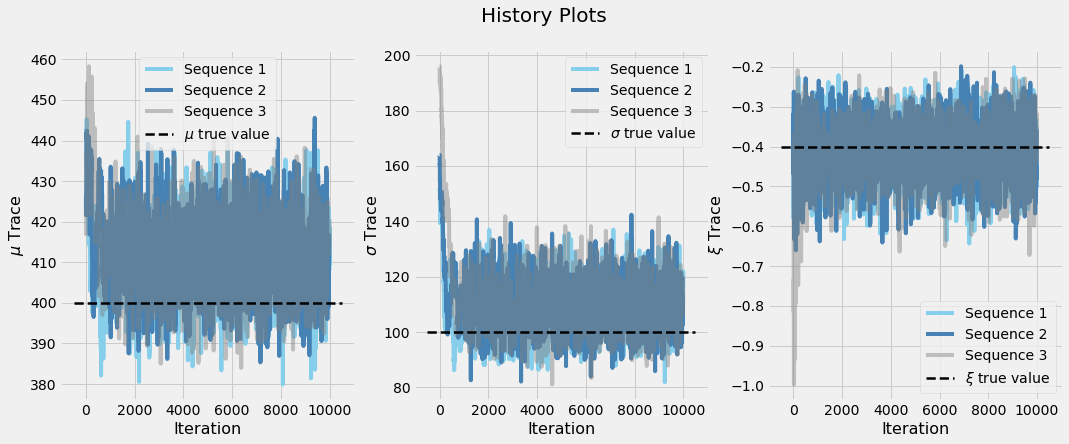

In [172]:
history_plots(mcmc_chains2, [r"$\mu$", r"$\sigma$", r"$\xi$"], [400, 100, -0.4])

***

<a id='gr-diagnostic_gev'></a>
***
<h2 align="center">Gelman-Rubin Diagnostic Results</h2>
[Back to top](#top)

<br>

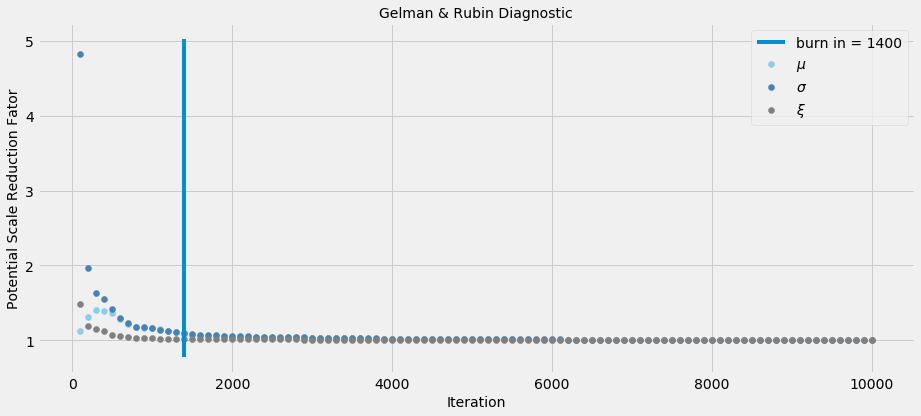

In [174]:
burnin2 = GR_result(mcmc_chains2, [r"$\mu$", r"$\sigma$", r"$\xi$"], t)

****

<a id='ac-function_gev'></a>
***
<h2 align="center">Auto Correlation Function Results</h2>
[Back to top](#top)

<br>

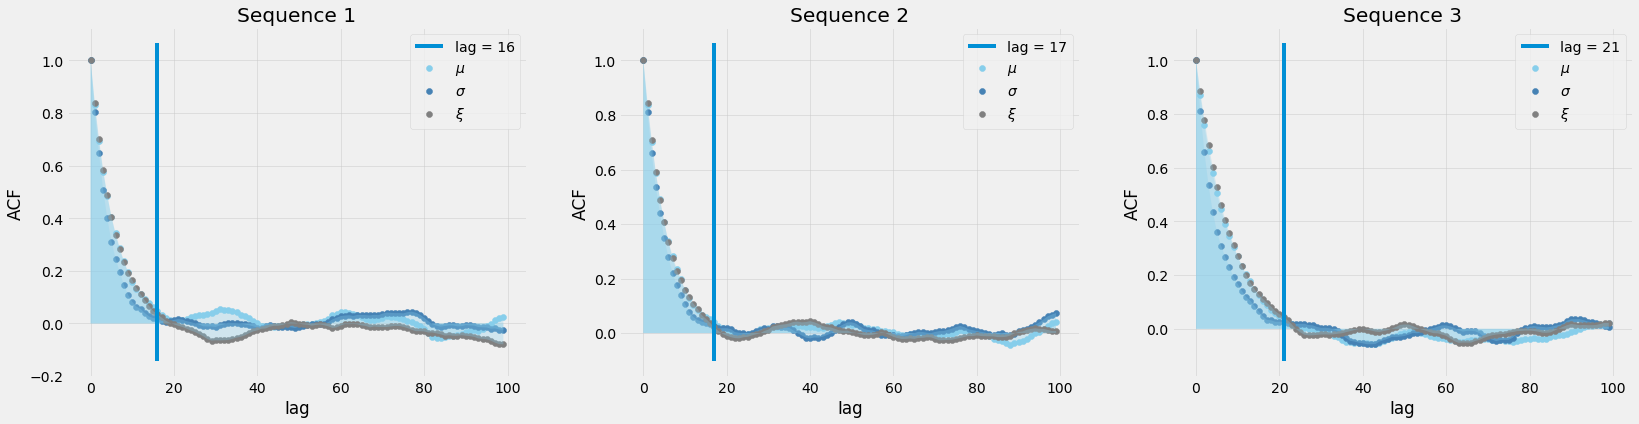

In [175]:
lags2 = acf_result(mcmc_chains2, [r"$\mu$", r"$\sigma$", r"$\xi$"], burnin2)

***

<a id='histograms_gev'></a>
***
<h2 align="center">Histograms For Each Parameter</h2>
[Back to top](#top)

<br>

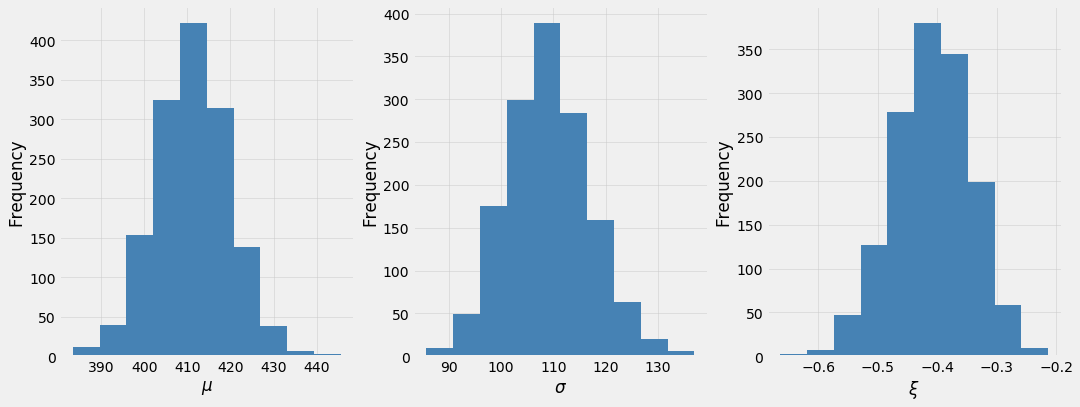

In [177]:
params_analysis = final_params_pool(mcmc_chains2, burnin2, lags2, [r"$\mu$", r"$\sigma$", r"$\xi$"])

***

<a id='max-ls_gev'></a>
***
<h2 align="center">Max Log-Posterior Score Parameter Set</h2>
[Back to top](#top)

<br>

In [178]:
max_params = max_ls_parameters(ls2, mcmc_chains2)

The parameters with max log-posterior score are [410.45064182783193, 106.80620751968556, -0.40852213411398475]


***

<a id='diagnostic-plots_gev'></a>
***
<h2 align="center">Diagnostic Plots</h2>
[Back to top](#top)

<br>

Now we have a pool of parameter sets which we can use to analysis. For the sea-level data, we usually have three diagnostic plots:

<br>

### 1. Probability Plot

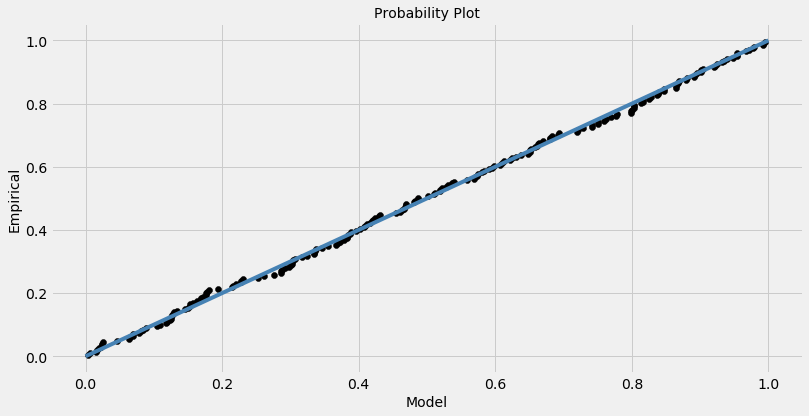

In [184]:
cdf = [stats.genextreme.cdf(x=np.sort(data_meas2)[i], c=max_params[2], loc=max_params[0], scale=max_params[1]) for i in range(len(data_meas2))]

plt.figure(figsize=(12, 6))
plt.scatter(cdf, [(i+1)/(len(data_meas2)+1) for i in range(len(data_meas2))], color='black')
plt.plot([0, 1], [0, 1], color='steelblue')
plt.title('Probability Plot', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Empirical', fontsize=14)

<br>

### 2. Quantile Plot

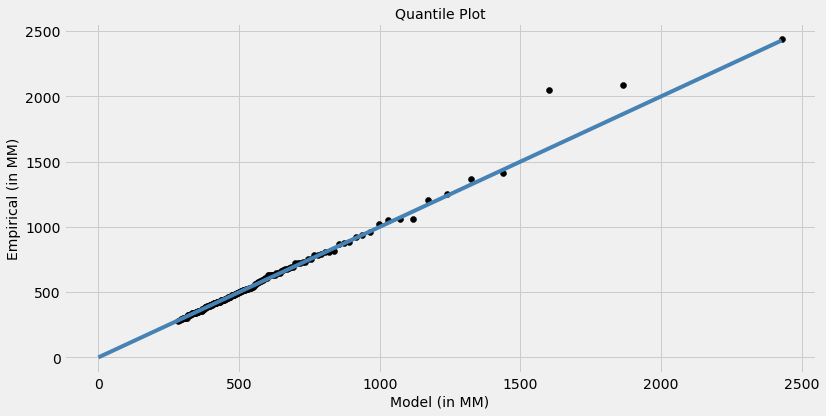

In [185]:
empirical = [stats.genextreme.ppf(q=(i+1)/(len(data_meas2)+1), c=max_params[2], loc=max_params[0], scale=max_params[1]) for i in range(len(data_meas2))]

plt.figure(figsize=(12, 6))
plt.scatter(empirical, np.sort(data_meas2), color='black')
plt.plot(np.arange(0, max(empirical)), np.arange(0, max(empirical)), color='steelblue')
plt.title('Quantile Plot', fontsize=14)
plt.xlabel('Model (in MM)', fontsize=14)
plt.ylabel('Empirical (in MM)', fontsize=14)

***

<br>

### 3. Return Level Plot

In [186]:
RP = np.arange(1, 501, 1)
RL = []
RL_max = []
percentile_95 = []
percentile_5 = []
percentile_995 = []
percentile_05 = []
for i in range(len(RP)):
    RL.append([])
    RL_max.append(stats.genextreme.ppf(q=(1-1/RP[i]), c=max_params[2], loc=max_params[0], scale=max_params[1]))
    for j in range(len(params_analysis)):
        RL[i].append(stats.genextreme.ppf(q=(1-1/RP[i]), c=params_analysis[j][2], loc=params_analysis[j][0], scale=params_analysis[j][1]))
for i in range(len(RL)):
    percentile_95.append(np.percentile((RL[i]), 95))
    percentile_5.append(np.percentile((RL[i]), 5))
    percentile_995.append(np.percentile((RL[i]), 99.5))
    percentile_05.append(np.percentile((RL[i]), 0.5))

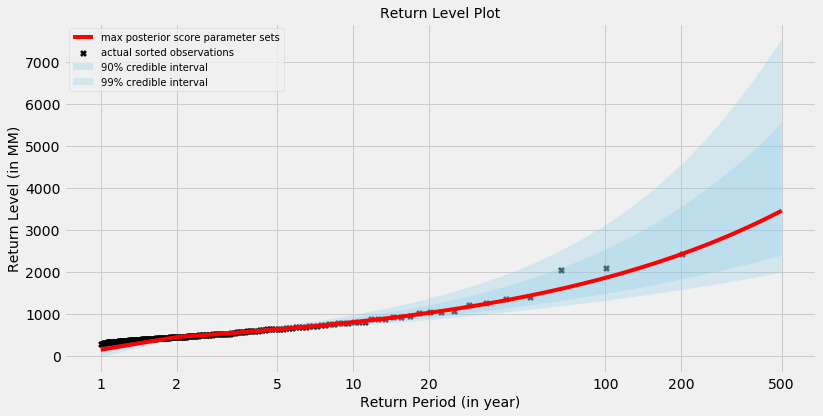

In [188]:
plt.figure(figsize=(12, 6))
plt.plot(np.log10(RP), RL_max, color='r', label='max posterior score parameter sets')
plt.scatter(np.log10([(len(data_meas2)+1)/(len(data_meas2)+1-k) for k in np.arange(1, len(data_meas2)+1, 1)]), np.sort(data_meas2), label='actual sorted observations', color='black', marker='X')
plt.fill_between(x=np.log10(RP), y1=percentile_95, y2=percentile_5, alpha=0.3, label='90% credible interval', facecolor='skyblue')
plt.fill_between(x=np.log10(RP), y1=percentile_995, y2=percentile_05, alpha=0.27, label='99% credible interval', facecolor='skyblue')
plt.legend(loc='upper left', fontsize=10)
plt.xticks(np.log10([1,2,5,10,20,100,200,500]), [1,2,5,10,20,100,200,500])
plt.title('Return Level Plot', fontsize=14)
plt.xlabel('Return Period (in year)', fontsize=14)
plt.ylabel('Return Level (in MM)', fontsize=14)

***

<br>

### 4. Density Plot

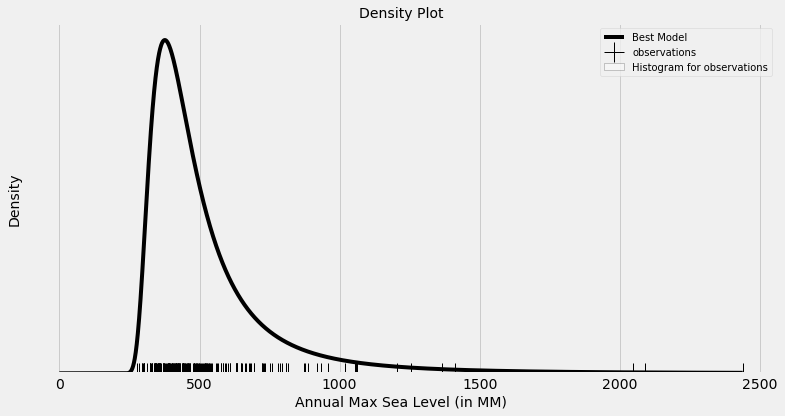

In [189]:
x_range = np.arange(0, max(data_meas2)+1, 0.5)
y_range = [stats.genextreme.pdf(x=xi, c=max_params[2], loc=max_params[0], scale=max_params[1]) for xi in x_range]

plt.figure(figsize=(12, 6))
plt.hist(data_meas, bins=np.linspace(min(data_meas2), max(data_meas2)), normed=True, edgecolor='black', label='Histogram for observations', color='white', alpha=0.4)
plt.plot(x_range, y_range, label='Best Model', color='black')
plt.plot(data_meas2, np.zeros_like(data_meas2), 'b+', ms=20, color='black', label='observations')
plt.legend(loc='best', fontsize=10)
plt.yticks([])
plt.title('Density Plot', fontsize=14)
plt.xlabel('Annual Max Sea Level (in MM)', fontsize=14)
plt.ylabel('Density', fontsize=14)